# Intro

This notebook provides analysis of preprocessed daily prices that can be later used for feature engineering and model buiding.

# Config

In [103]:
# # Set dark mode as default
# import matplotlib.pyplot as plt
# import plotly.io as pio
# plt.style.use("dark_background")
# pio.templates.default = "plotly_dark"

# Imports
from warnings import catch_warnings, filterwarnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from scipy.signal import welch
from scipy.special import digamma
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm.auto import tqdm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tools.sm_exceptions import InterpolationWarning
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import StandardScaler


from market_regime.data import get_data
from market_regime.features import calculate_log_returns

# Global variables

# Functions
def _tight_symmetric_ylim(ax, pad=0.05, default=0.1):
    """Adjust y-scale for ACF/PACF to be comparable and not dominated by lag-0"""
    ys = []
    for line in ax.lines:
        y = line.get_ydata()
        if y is None or len(y) == 0:
            continue
        ys.append(np.asarray(y, dtype=float))
    if not ys:
        ax.set_ylim(-default, default)
        return
    y_all = np.concatenate(ys)
    y_all = y_all[np.isfinite(y_all)]
    if y_all.size == 0:
        ax.set_ylim(-default, default)
        return
    m = np.max(np.abs(y_all))
    m = max(m, default)
    ax.set_ylim(-(m * (1 + pad)), m * (1 + pad))

# Data

## Import

In [104]:
# Data import (with labels)
df = get_data()

In [105]:
df

,delivery_date,open_t,close_t,target
trading_date,,,,
2015-11-30,2016-01-01,17.85,18.150,-1.0
2015-12-01,2016-01-01,18.05,18.100,-1.0
2015-12-02,2016-01-01,18.15,17.675,-1.0
2015-12-03,2016-01-01,17.64,17.375,-1.0
2015-12-04,2016-01-01,17.35,17.450,-1.0
...,...,...,...,...
2024-11-22,2024-12-01,48.80,46.935,-1.0
2024-11-25,2024-12-01,47.05,47.910,0.0
2024-11-26,2024-12-01,47.50,46.575,0.0


## Exploration

### Price

In [106]:
price = df["close_t"]

In [107]:
price.describe()    # NOTE: it's always positive

count    2305.000000
mean       36.962315
std        41.922437
min         3.535000
25%        14.800000
50%        20.370000
75%        37.750000
max       310.500000
Name: close_t, dtype: float64

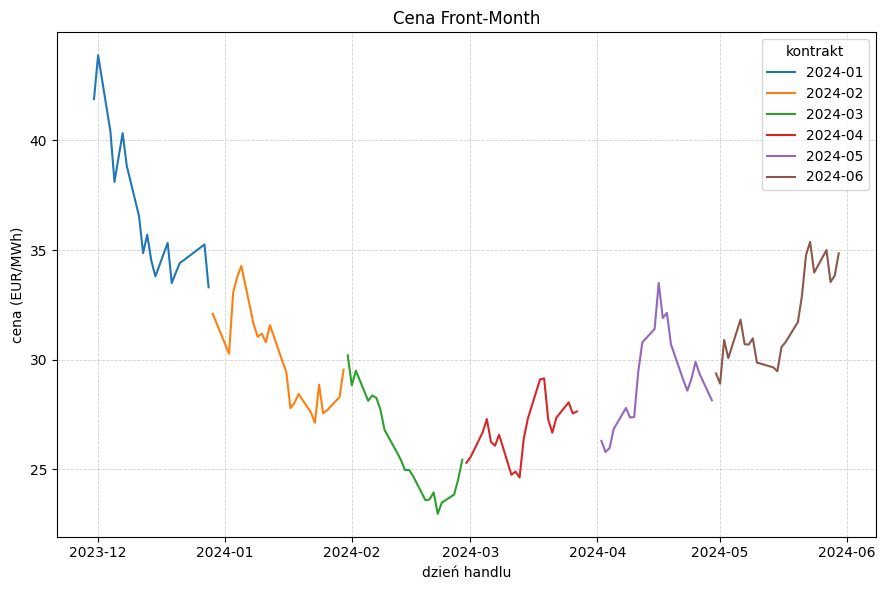

In [108]:
tmp = df[(df["delivery_date"] >= "2024-01-01") & (df["delivery_date"] < "2024-07-01")].reset_index()
tmp["dzień handlu"] = tmp["trading_date"]
tmp["kontrakt"] = tmp["delivery_date"].dt.to_period("M")
tmp["cena (EUR/MWh)"] = tmp["close_t"]

plt.figure(figsize=(9, 6))
ax = sns.lineplot(
    tmp,
    x="dzień handlu",
    y="cena (EUR/MWh)",
    hue="kontrakt",
)

ax.set_title("Cena Front-Month")
ax.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.6)

plt.tight_layout()
plt.show()


#### Autocorrelation

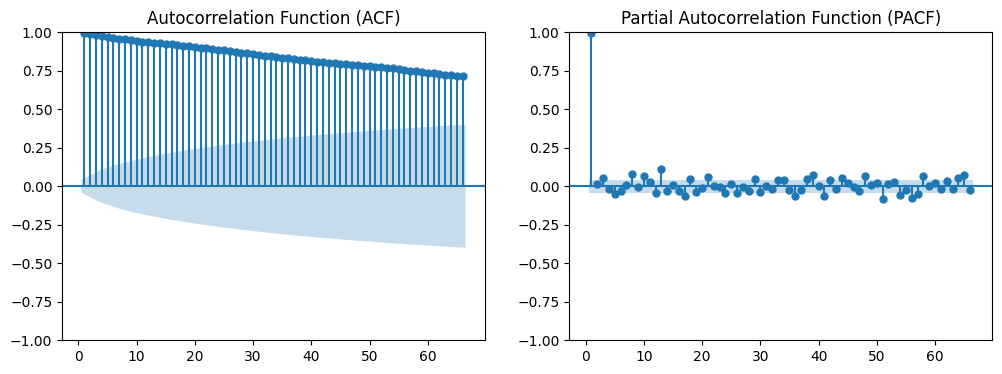

In [109]:
# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(price, lags=22*3, zero=False, ax=ax[0])
plot_pacf(price, lags=22*3, zero=False, ax=ax[1])
ax[0].set_title("Autocorrelation Function (ACF)")
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

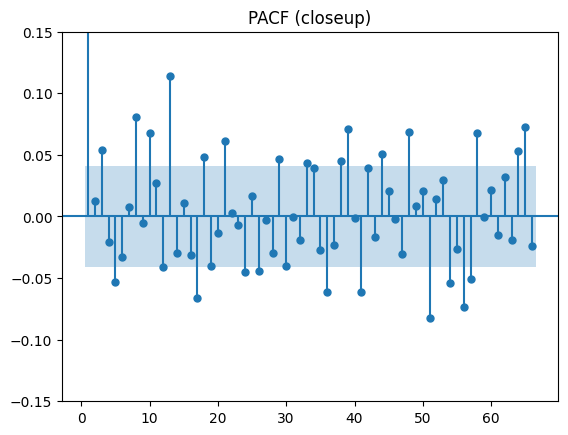

In [110]:
plot_pacf(price, lags=22*3, zero=False)
plt.ylim(-0.15, 0.15)
plt.title("PACF (closeup)")
plt.show()

#### Stationarity

**ADF test**

- $H_0$: series has a unit root
- $H_1$: $\sim H_0$ 

In [111]:
adf_stat, adf_pvalue, _, _, adf_crit_values, _ = adfuller(x=price, regression="n")
print(f"ADF test stat: {adf_stat}")
print(f"ADF pvalue: {adf_pvalue}")
print("ADF critical values:")
for pct, val in adf_crit_values.items():
    print(f"  {pct}: {val}")

if adf_pvalue < 0.05:
    result_msg = "H_0 rejected => the series has NO unit root (stationary)."
else:
    result_msg = "failed to reject H_0 => the series has a unit root (non-stationary)."
print(f"\nResult: {result_msg}")

ADF test stat: -1.5268808751914413
ADF pvalue: 0.11903727836577854
ADF critical values:
  1%: -2.5667195919454913
  5%: -1.9411182431292546
  10%: -1.6167042309124697

Result: failed to reject H_0 => the series has a unit root (non-stationary).


**KPSS test**

- $H_0$: the process is trend stationary
- $H_1$: the series has a unit root (series is not stationary)

In [112]:
with catch_warnings():
    filterwarnings("ignore", category=InterpolationWarning)
    kpss_stat, kpss_pvalue, _, kpss_crit_values = kpss(x=price, regression="c")
print(f"KPSS test stat: {kpss_stat}")
print(f"KPSS pvalue: {kpss_pvalue}")
print("KPSS critical values:")
for pct, val in kpss_crit_values.items():
    print(f"  {pct}: {val}")
result_msg = "H_0 rejected." if kpss_pvalue < 0.05 else "failed to reject H_0."
print(f"\nResult: {result_msg}")

KPSS test stat: 2.212359971367429
KPSS pvalue: 0.01
KPSS critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739

Result: H_0 rejected.


Price series is not stationary. Next step is to calculate log returns and analyze them.

### Price Diff

In [113]:
df["close_t-1"] = df.groupby("delivery_date")["close_t"].shift(1)

<Axes: xlabel='trading_date'>

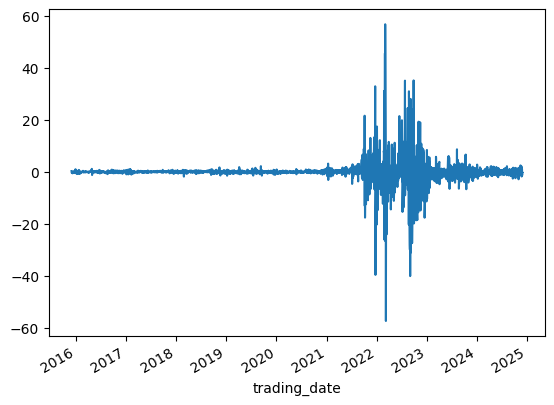

In [114]:
# price difference - plot
(df["close_t"] - df["close_t-1"].fillna(df["open_t"])).plot()
# NOTE: extreme heteroskedasticity present, visible lack of stationarity

<Axes: ylabel='Count'>

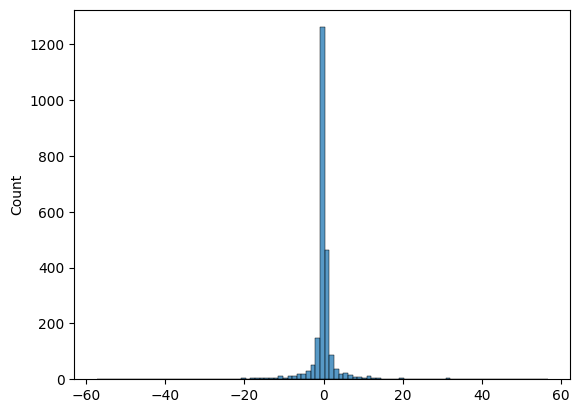

In [115]:
# price difference - histogram
sns.histplot(df["close_t"] - df["close_t-1"].fillna(df["open_t"]))

<Axes: xlabel='trading_date'>

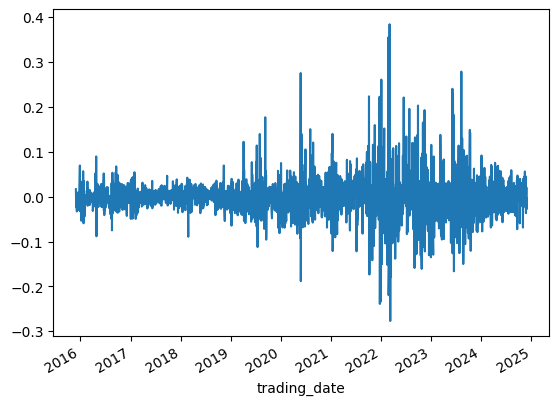

In [116]:
# price difference % - plot
(df["close_t"] / df["close_t-1"].fillna(df["open_t"]) - 1).plot()
# NOTE: visibly nore stationary than simple differencing

<Axes: ylabel='Count'>

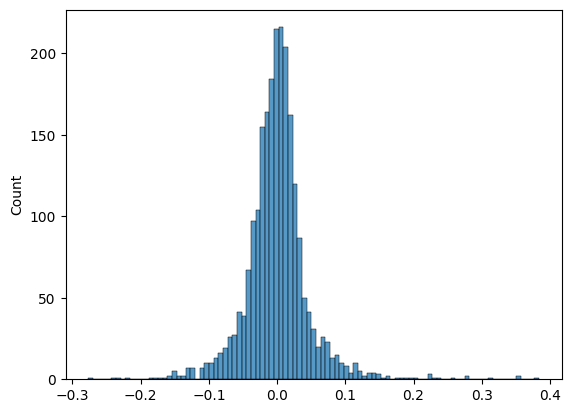

In [117]:
# price difference % - histogram
sns.histplot(df["close_t"] / df["close_t-1"].fillna(df["open_t"]) - 1)
# NOTE: assymetry is present between positive and negative price moves

### Log Returns

In [118]:
lr = calculate_log_returns(df, open_col="open_t", close_col="close_t")

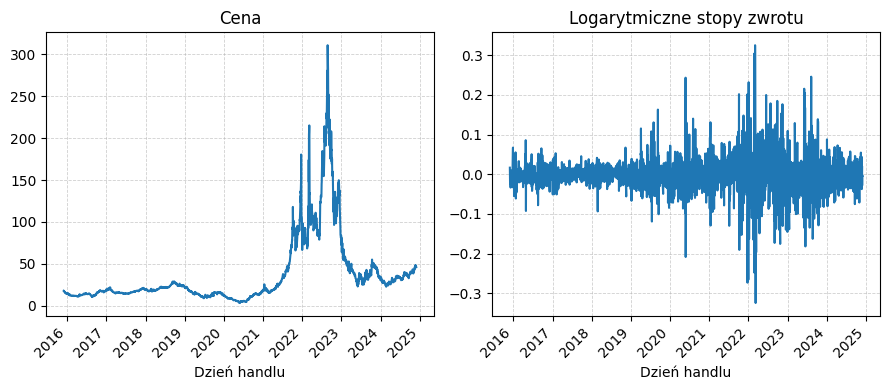

In [119]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

axes[0].plot(price)
axes[0].set_title("Cena")
axes[0].set_xlabel("Dzień handlu")
axes[0].grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.6)

axes[1].plot(lr)
axes[1].set_title("Logarytmiczne stopy zwrotu")
axes[1].set_xlabel("Dzień handlu")
axes[1].grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.6)

for ax in axes:
    ax.tick_params(axis="x", labelrotation=45)
    for label in ax.get_xticklabels():
        label.set_ha("right")
        
fig.tight_layout()
plt.show()

<Axes: xlabel='log_return_t', ylabel='Count'>

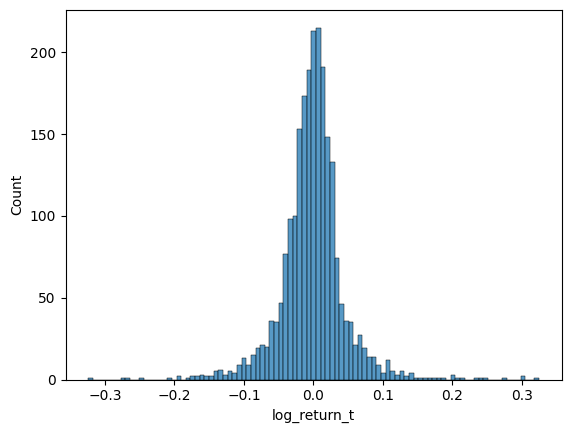

In [120]:
sns.histplot(lr) # NOTE: assymetry that was present in pct price diff is gone 

#### Normality

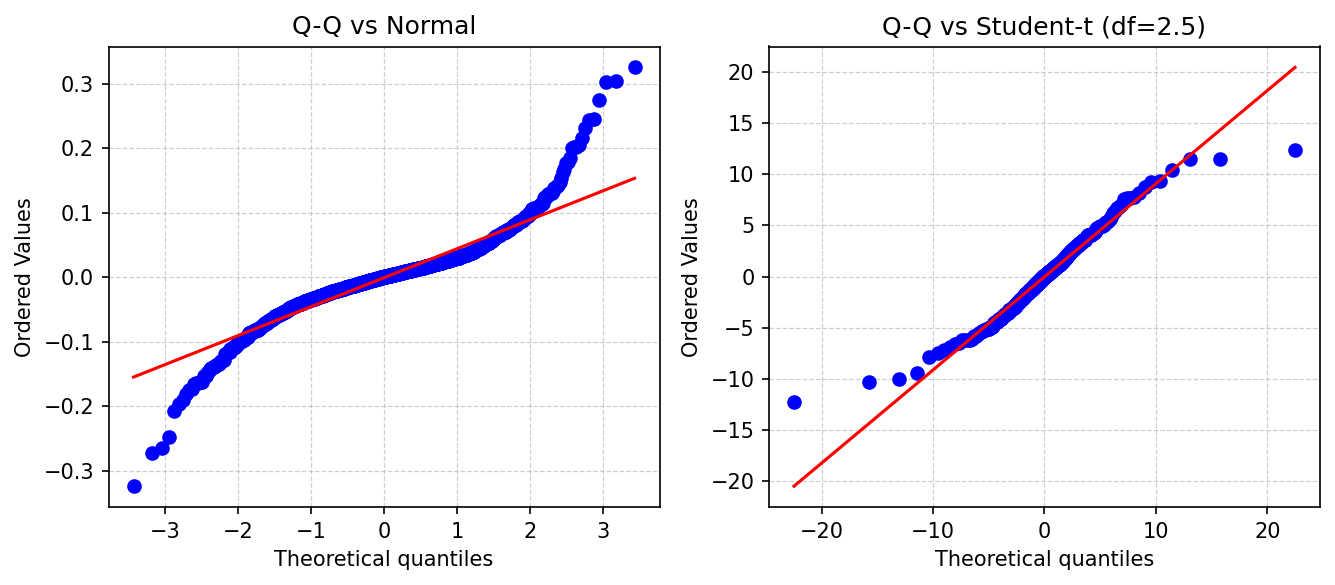

In [121]:
x = np.asarray(lr, dtype=float)
x = x[np.isfinite(x)]

# fit t for the t Q-Q plot
dff, loc, scale = stats.t.fit(x)
z = (x - loc) / scale

fig, axes = plt.subplots(1, 2, figsize=(9, 4), dpi=150)

# Q-Q vs Normal
stats.probplot(x, dist="norm", plot=axes[0])
axes[0].set_title("Q-Q vs Normal")
axes[0].grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.6)

# Q-Q vs Student-t (standardized)
stats.probplot(z, dist=stats.t, sparams=(dff,), plot=axes[1])
axes[1].set_title(f"Q-Q vs Student-t (df={dff:.3g})")
axes[1].grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.6)

fig.tight_layout()
plt.show()

In [122]:
# normality test (H0: Normal)
x = np.asarray(lr, dtype=float)
x = x[np.isfinite(x)]

stat, p = stats.normaltest(x)  # D’Agostino-Pearson K^2
print(f"Normality test (D'Agostino K^2): stat={stat:.6g}, p={p:.6g}")

Normality test (D'Agostino K^2): stat=371.863, p=1.78207e-81


In [123]:
# Student-t "test" (fit t, then KS vs fitted t; H0: t(df, loc, scale))
x = np.asarray(lr, dtype=float)
x = x[np.isfinite(x)]

dff, loc, scale = stats.t.fit(x)
D, p = stats.kstest(x, "t", args=(dff, loc, scale))

print(f"Student-t fit: df={dff:.6g}, loc={loc:.6g}, scale={scale:.6g}")
print(f"KS vs fitted t: D={D:.6g}, p={p:.6g}")

Student-t fit: df=2.49773, loc=-0.000447763, scale=0.0264043
KS vs fitted t: D=0.0195446, p=0.337654


#### Stationarity

ADF test

- $H_0$: series has a unit root
- $H_1$: $\sim H_0$ 

In [124]:
adf_stat, adf_pvalue, _, _, adf_crit_values, _ = adfuller(x=lr, regression="n")
print(f"ADF test stat: {adf_stat}")
print(f"ADF pvalue: {adf_pvalue}")
print("ADF critical values:")
for pct, val in adf_crit_values.items():
    print(f"  {pct}: {val}")

if adf_pvalue < 0.05:
    result_msg = "H_0 rejected => the series has NO unit root (stationary)."
else:
    result_msg = "failed to reject H_0 => the series has a unit root (non-stationary)."
print(f"\nResult: {result_msg}")

ADF test stat: -24.244326441562027
ADF pvalue: 0.0
ADF critical values:
  1%: -2.5667123495311546
  5%: -1.9411173648459408
  10%: -1.6167050824409557

Result: H_0 rejected => the series has NO unit root (stationary).


KPSS test

- $H_0$: the process is trend stationary
- $H_1$: the series has a unit root (series is not stationary)

In [125]:
with catch_warnings():
    filterwarnings("ignore", category=InterpolationWarning)
    kpss_stat, kpss_pvalue, _, kpss_crit_values = kpss(x=lr, regression="c")
print(f"KPSS test stat: {kpss_stat}")
print(f"KPSS pvalue: {kpss_pvalue}")
print("KPSS critical values:")
for pct, val in kpss_crit_values.items():
    print(f"  {pct}: {val}")
result_msg = "H_0 rejected." if kpss_pvalue < 0.05 else "failed to reject H_0."
print(f"\nResult: {result_msg}")

KPSS test stat: 0.11003811808660335
KPSS pvalue: 0.1
KPSS critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739

Result: failed to reject H_0.


Both test suggests that log returns are stationary

#### Autocorrelation

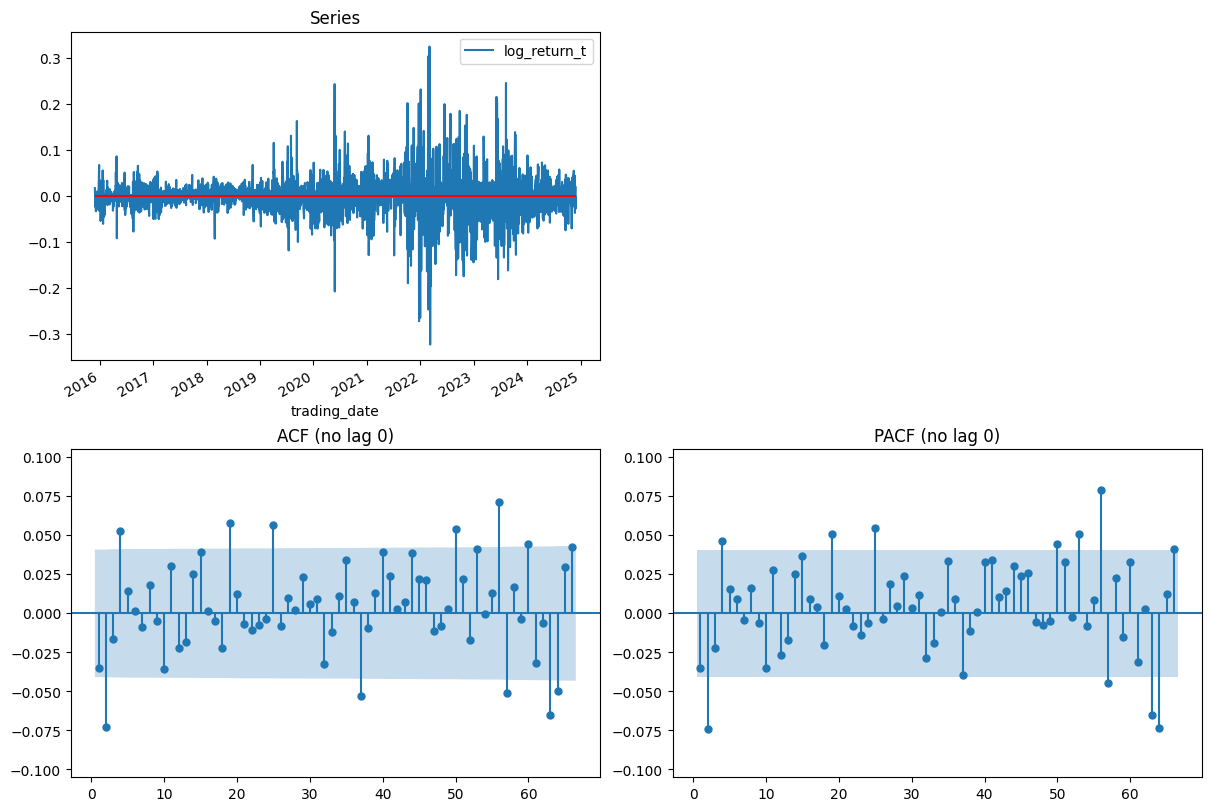

In [126]:
lags = 22 * 3
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

# Log Returns plot
ax0 = axes[0, 0]
lr.plot(ax=ax0, legend=True)
ax0.hlines(y=0, xmin=lr.index.min(), xmax=lr.index.max(), color="red")
ax0.set_title("Series")

# ACF
ax1 = axes[1, 0]
plot_acf(lr, ax=ax1, lags=lags, zero=False)
ax1.set_title("ACF (no lag 0)")
_tight_symmetric_ylim(ax1)

# PACF
ax2 = axes[1, 1]
plot_pacf(lr, ax=ax2, lags=lags, zero=False, method="ywm")
ax2.set_title("PACF (no lag 0)")
_tight_symmetric_ylim(ax2)

# Remove not used plot in grid
axes[0, 1].remove()

plt.show()

Ljung-Box (white noise test)

- $H_0$: the data is not correlated.
- $H_1$: the data exhibit serial correlation.

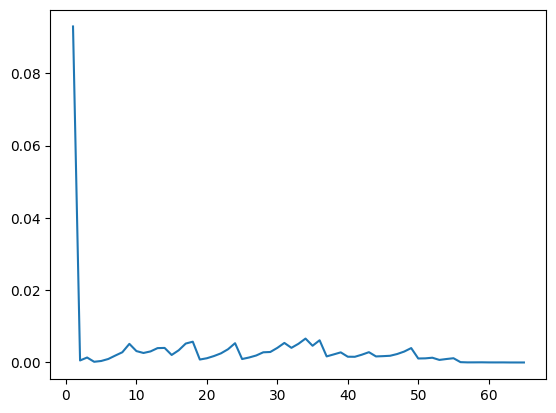

In [127]:
lb = acorr_ljungbox(lr, lags=range(1, 66), return_df=True)
lb["lb_pvalue"].plot()
plt.show()

#### Seasonality

day of week

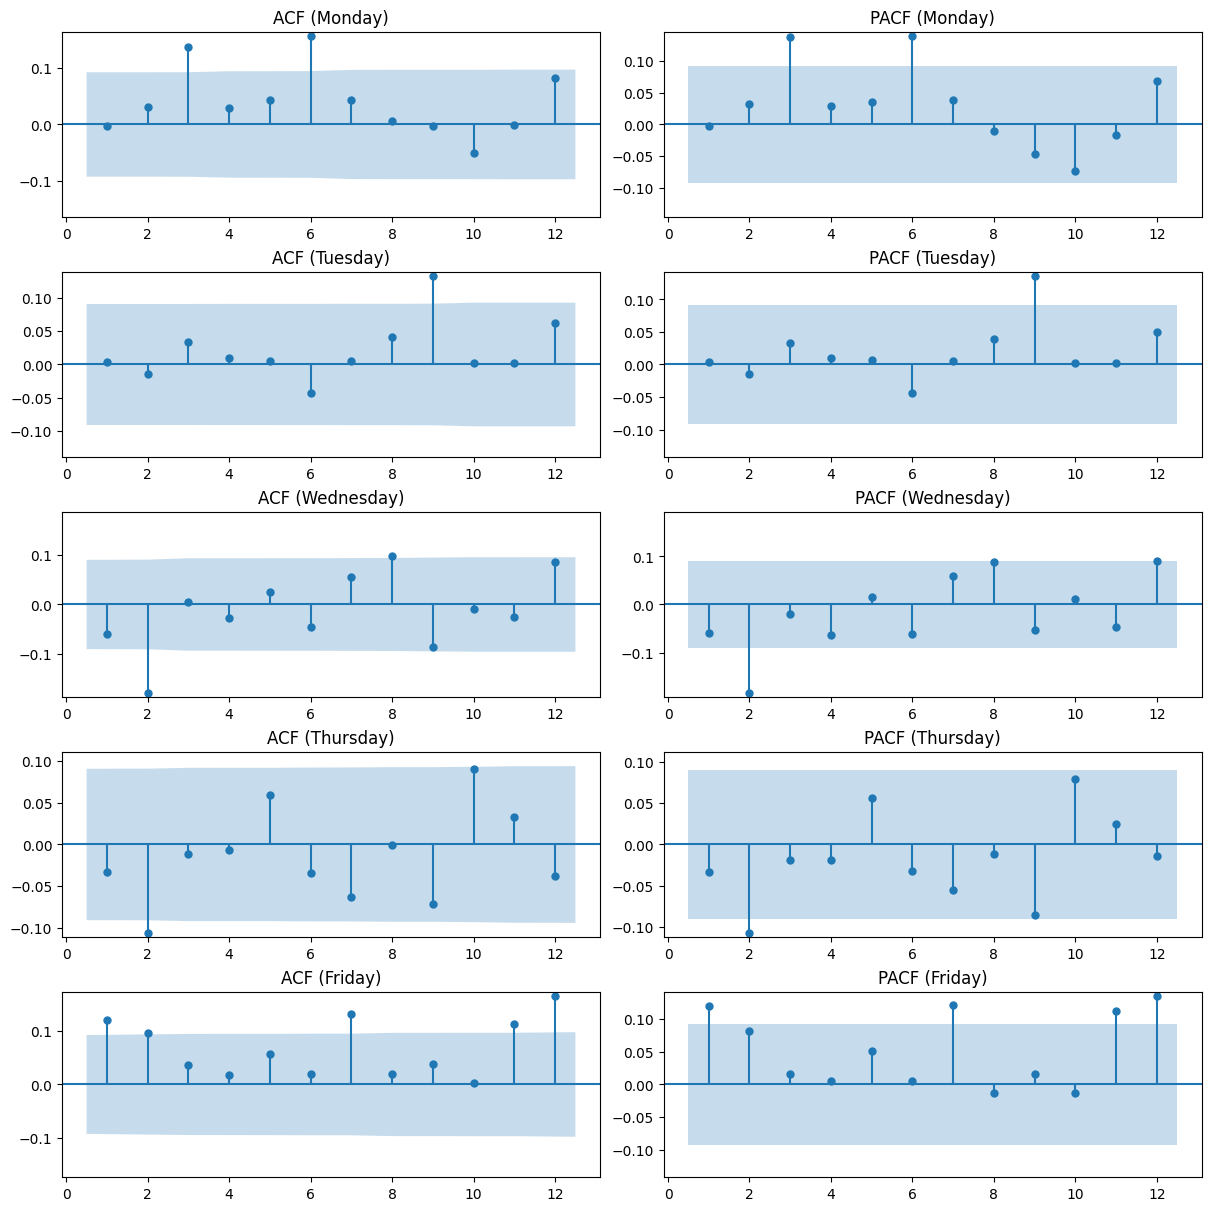

In [128]:
df_dow = lr.to_frame()
df_dow["dow"] = df_dow.index.day_of_week

lags = 12
fig, axes = plt.subplots(5, 2, figsize=(12, 12), constrained_layout=True)
day_names = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
}
for day in day_names.keys():
    # ACF
    ax1 = axes[day, 0]
    plot_acf(lr[lr.index.day_of_week == day], ax=ax1, lags=lags, zero=False)
    ax1.set_title(f"ACF ({day_names[day]})")
    _tight_symmetric_ylim(ax1)

    # PACF
    ax2 = axes[day, 1]
    plot_pacf(lr[lr.index.day_of_week == day], ax=ax2, lags=lags, zero=False, method="ywm")
    ax2.set_title(f"PACF ({day_names[day]})")
    _tight_symmetric_ylim(ax2)

plt.show()

In [129]:
df_x = pd.get_dummies(df_dow["dow"], prefix="day_of_week", drop_first=True).astype(int)
df_x = sm.add_constant(df_x)
s_y = df_dow["log_return_t"]

res = sm.OLS(endog=s_y, exog=df_x).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_return_t   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.822
Date:                Wed, 28 Jan 2026   Prob (F-statistic):             0.0237
Time:                        01:19:03   Log-Likelihood:                 3769.2
No. Observations:                2305   AIC:                            -7528.
Df Residuals:                    2300   BIC:                            -7500.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0020      0.002     -0.920      0.357      -0.006       0.002
day_of_week_1     0.0058      0.003      1.866      0.062      -0.000       0.012
day_of_week_2     0.0015      0.003      0.469      0.639      -0.005       0.008
day_of_week_3     0.0023      0.003      0.726      0.468      -0.004       0.008
day_of_week_4    -0.0044      0.003     -1.390      0.165      -0.011       0.002
==============================================================================
Omnibus:                      371.816   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5528.038
Skew:                           0.248   Prob(JB):                         0.00
Kurtosis:                      10.571   Cond. No.                         5.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [130]:
res = sm.OLS(endog=s_y, exog=df_x).fit(cov_type="HAC", cov_kwds={"maxlags": 21})    # better for autocorrelation in variance
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_return_t   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.134
Date:                Wed, 28 Jan 2026   Prob (F-statistic):             0.0742
Time:                        01:19:03   Log-Likelihood:                 3769.2
No. Observations:                2305   AIC:                            -7528.
Df Residuals:                    2300   BIC:                            -7500.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0020      0.003     -0.804      0.421      -0.007       0.003
day_of_week_1     0.0058      0.003      1.834      0.067      -0.000       0.012
day_of_week_2     0.0015      0.003      0.464      0.643      -0.005       0.008
day_of_week_3     0.0023      0.003      0.691      0.490      -0.004       0.009
day_of_week_4    -0.0044      0.004     -1.223      0.221      -0.011       0.003
==============================================================================
Omnibus:                      371.816   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5528.038
Skew:                           0.248   Prob(JB):                         0.00
Kurtosis:                      10.571   Cond. No.                         5.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 21 lags and without small sample correction
"""

Some correlation structure exists, but it's weak, and it's hard to exploit it for predictability.

day of month

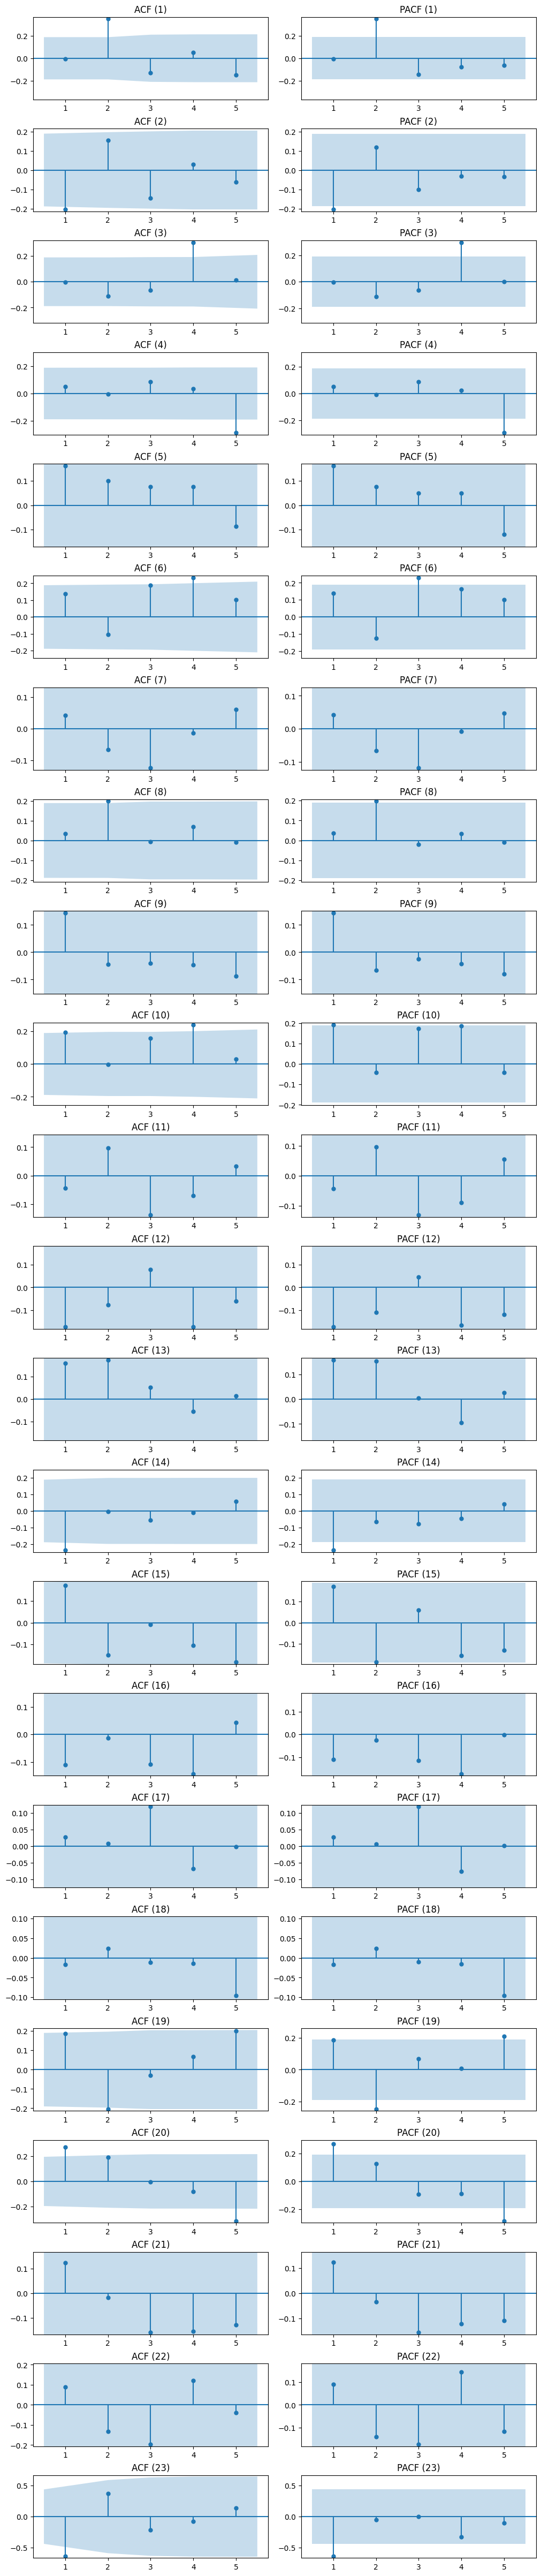

In [131]:
df_dom = df.join(lr).reset_index()
df_dom["bdom"] = df_dom.groupby("delivery_date")["trading_date"].rank().astype(int)
df_dom = df_dom.set_index("trading_date")

lags = 5
fig, axes = plt.subplots(df_dom["bdom"].max(), 2, figsize=(10, 48), constrained_layout=True)
for day in range(df_dom["bdom"].min(), df_dom["bdom"].max() + 1):
    # ACF
    ax1 = axes[day-1, 0]
    plot_acf(df_dom.loc[df_dom["bdom"] == day, "log_return_t"], ax=ax1, lags=lags, zero=False)
    ax1.set_title(f"ACF ({day})")
    _tight_symmetric_ylim(ax1)

    # PACF
    ax2 = axes[day-1, 1]
    plot_pacf(df_dom.loc[df_dom["bdom"] == day, "log_return_t"], ax=ax2, lags=lags, zero=False, method="ywm")
    ax2.set_title(f"PACF ({day})")
    _tight_symmetric_ylim(ax2)

plt.show()

In [132]:
df_dom["month"] = df_dom.index.month
s_y = df_dom["log_return_t"]

In [133]:
df_x = pd.get_dummies(df_dom["bdom"], prefix="bday_of_month", drop_first=True).astype(int)
df_x = sm.add_constant(df_x)

In [134]:
res = sm.OLS(endog=s_y, exog=df_x).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_return_t   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.133
Date:                Wed, 28 Jan 2026   Prob (F-statistic):              0.302
Time:                        01:19:05   Log-Likelihood:                 3776.0
No. Observations:                2305   AIC:                            -7506.
Df Residuals:                    2282   BIC:                            -7374.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0098      0.005     -2.154      0.031      -0.019      -0.001
bday_of_month_2      0.0080      0.006      1.244      0.214      -0.005       0.021
bday_of_month_3      0.0145      0.006      2.262      0.024       0.002       0.027
bday_of_month_4      0.0121      0.006      1.888      0.059      -0.000       0.025
bday_of_month_5      0.0089      0.006      1.377      0.169      -0.004       0.021
bday_of_month_6      0.0099      0.006      1.538      0.124      -0.003       0.023
bday_of_month_7      0.0095      0.006      1.476      0.140      -0.003       0.022
bday_of_month_8      0.0124      0.006      1.927      0.054      -0.000       0.025
bday_of_month_9      0.0022      0.006      0.346      0.729      -0.010       0.015
bday_of_month_10     0.0178      0.006      2.761      0.006       0.005       0.030
bday_of_month_11     0.0104      0.006      1.622      0.105      -0.002       0.023
bday_of_month_12     0.0021      0.006      0.331      0.741      -0.010       0.015
bday_of_month_13     0.0040      0.006      0.618      0.537      -0.009       0.017
bday_of_month_14     0.0085      0.006      1.324      0.186      -0.004       0.021
bday_of_month_15     0.0091      0.006      1.423      0.155      -0.003       0.022
bday_of_month_16     0.0074      0.006      1.147      0.251      -0.005       0.020
bday_of_month_17     0.0124      0.006      1.924      0.054      -0.000       0.025
bday_of_month_18     0.0188      0.006      2.930      0.003       0.006       0.031
bday_of_month_19     0.0017      0.006      0.259      0.796      -0.011       0.014
bday_of_month_20     0.0066      0.007      1.009      0.313      -0.006       0.019
bday_of_month_21     0.0068      0.007      0.973      0.331      -0.007       0.020
bday_of_month_22     0.0130      0.008      1.646      0.100      -0.002       0.029
bday_of_month_23     0.0050      0.012      0.435      0.664      -0.018       0.028
==============================================================================
Omnibus:                      375.242   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5709.334
Skew:                           0.246   Prob(JB):                         0.00
Kurtosis:                      10.694   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [135]:
res = sm.OLS(endog=s_y, exog=df_x).fit(cov_type="HAC", cov_kwds={"maxlags": 21})
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_return_t   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.261
Date:                Wed, 28 Jan 2026   Prob (F-statistic):              0.186
Time:                        01:19:05   Log-Likelihood:                 3776.0
No. Observations:                2305   AIC:                            -7506.
Df Residuals:                    2282   BIC:                            -7374.
Df Model:                          22                                         
Covariance Type:                  HAC                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0098      0.005     -2.045      0.041      -0.019      -0.000
bday_of_month_2      0.0080      0.008      0.952      0.341      -0.008       0.024
bday_of_month_3      0.0145      0.007      1.942      0.052      -0.000       0.029
bday_of_month_4      0.0121      0.007      1.836      0.066      -0.001       0.025
bday_of_month_5      0.0089      0.007      1.235      0.217      -0.005       0.023
bday_of_month_6      0.0099      0.005      1.879      0.060      -0.000       0.020
bday_of_month_7      0.0095      0.007      1.385      0.166      -0.004       0.023
bday_of_month_8      0.0124      0.007      1.839      0.066      -0.001       0.026
bday_of_month_9      0.0022      0.006      0.376      0.707      -0.009       0.014
bday_of_month_10     0.0178      0.007      2.662      0.008       0.005       0.031
bday_of_month_11     0.0104      0.007      1.500      0.134      -0.003       0.024
bday_of_month_12     0.0021      0.006      0.355      0.722      -0.010       0.014
bday_of_month_13     0.0040      0.007      0.578      0.563      -0.009       0.017
bday_of_month_14     0.0085      0.006      1.467      0.142      -0.003       0.020
bday_of_month_15     0.0091      0.007      1.372      0.170      -0.004       0.022
bday_of_month_16     0.0074      0.007      1.131      0.258      -0.005       0.020
bday_of_month_17     0.0124      0.006      1.987      0.047       0.000       0.025
bday_of_month_18     0.0188      0.006      3.385      0.001       0.008       0.030
bday_of_month_19     0.0017      0.008      0.213      0.831      -0.014       0.017
bday_of_month_20     0.0066      0.007      0.971      0.332      -0.007       0.020
bday_of_month_21     0.0068      0.006      1.153      0.249      -0.005       0.018
bday_of_month_22     0.0130      0.006      2.054      0.040       0.001       0.025
bday_of_month_23     0.0050      0.009      0.544      0.587      -0.013       0.023
==============================================================================
Omnibus:                      375.242   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5709.334
Skew:                           0.246   Prob(JB):                         0.00
Kurtosis:                      10.694   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 21 lags and without small sample correction
"""

In [136]:
df_x = pd.get_dummies(df_dom["month"], prefix="month", drop_first=True).astype(int)
df_x = sm.add_constant(df_x)

In [137]:
res = sm.OLS(endog=s_y, exog=df_x).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_return_t   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.912
Date:                Wed, 28 Jan 2026   Prob (F-statistic):             0.0336
Time:                        01:19:06   Log-Likelihood:                 3774.0
No. Observations:                2305   AIC:                            -7524.
Df Residuals:                    2293   BIC:                            -7455.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.003     -0.711      0.477      -0.009       0.004
month_2       -0.0040      0.005     -0.816      0.415      -0.014       0.006
month_3        0.0027      0.005      0.565      0.572      -0.007       0.012
month_4        0.0022      0.005      0.449      0.653      -0.007       0.012
month_5       -0.0026      0.005     -0.554      0.580      -0.012       0.007
month_6        0.0083      0.005      1.722      0.085      -0.001       0.018
month_7        0.0024      0.005      0.498      0.619      -0.007       0.012
month_8        0.0069      0.005      1.458      0.145      -0.002       0.016
month_9        0.0048      0.005      0.990      0.322      -0.005       0.014
month_10      -0.0030      0.005     -0.637      0.524      -0.012       0.006
month_11       0.0058      0.005      1.208      0.227      -0.004       0.015
month_12      -0.0067      0.005     -1.386      0.166      -0.016       0.003
==============================================================================
Omnibus:                      372.562   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5504.816
Skew:                           0.254   Prob(JB):                         0.00
Kurtosis:                      10.554   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [138]:
res = sm.OLS(endog=s_y, exog=df_x).fit(cov_type="HAC", cov_kwds={"maxlags": 21})
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_return_t   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.656
Date:                Wed, 28 Jan 2026   Prob (F-statistic):            0.00220
Time:                        01:19:06   Log-Likelihood:                 3774.0
No. Observations:                2305   AIC:                            -7524.
Df Residuals:                    2293   BIC:                            -7455.
Df Model:                          11                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.002     -1.042      0.297      -0.007       0.002
month_2       -0.0040      0.003     -1.310      0.190      -0.010       0.002
month_3        0.0027      0.004      0.704      0.482      -0.005       0.010
month_4        0.0022      0.003      0.672      0.502      -0.004       0.009
month_5       -0.0026      0.004     -0.689      0.491      -0.010       0.005
month_6        0.0083      0.004      2.146      0.032       0.001       0.016
month_7        0.0024      0.003      0.690      0.490      -0.004       0.009
month_8        0.0069      0.004      1.938      0.053   -7.74e-05       0.014
month_9        0.0048      0.004      1.188      0.235      -0.003       0.013
month_10      -0.0030      0.004     -0.720      0.472      -0.011       0.005
month_11       0.0058      0.003      1.862      0.063      -0.000       0.012
month_12      -0.0067      0.006     -1.173      0.241      -0.018       0.005
==============================================================================
Omnibus:                      372.562   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5504.816
Skew:                           0.254   Prob(JB):                         0.00
Kurtosis:                      10.554   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 21 lags and without small sample correction
"""

Some monthly correlation structure exists, but it's weak, exists only for specific days, and it's hard to exploit for predictability.

#### Heteroskedasticity

In [139]:
# Engle's ARCH LM test
lags = 22
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(lr, nlags=lags)

print(f"Engle ARCH LM test (nlags={lags})")
print(f"  LM stat = {lm_stat:.4f}, p-value = {lm_pvalue:.4g}")
print(f"  F  stat = {f_stat:.4f}, p-value = {f_pvalue:.4g}")

# Ljung-Box on squared returns (often lights up with ARCH)
lb = acorr_ljungbox(lr**2, lags=lags, return_df=True)
print(f"\nLjung-Box on squared returns (up to lag {lags})")
print(lb.tail(1))

Engle ARCH LM test (nlags=22)
  LM stat = 651.9211, p-value = 1.053e-123
  F  stat = 41.0588, p-value = 3.497e-147

Ljung-Box on squared returns (up to lag 22)
        lb_stat  lb_pvalue
22  2167.489937        0.0


heteroskedasticity is present

#### Forecastability measures

##### Spectral forecastability

`score` = 1 − `normalized_spectral_entropy`

Forecastable Component Analysis formalizes forecastability using the spectral entropy of the (normalized) spectral density: signals with power concentrated at a few frequencies (strong cyclical/seasonal structure) have low spectral entropy (high forecastability), while series close to white noise have flat spectra (high entropy, low forecastability). 

Spectral entropy is grounded in Shannon’s entropy concept applied to a normalized power spectrum (a probability-like distribution over frequencies).

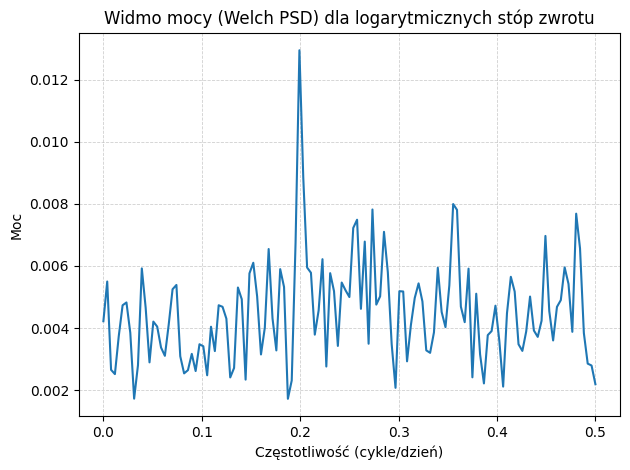

Entropy: 4.7969
Normalized entropy: 0.9871 (between [0, 1])
Forecastability score: 0.0129 (between [0, 1], higher = more forecastable)


In [140]:
x = lr.values

# Calculate Welch PSD
nperseg = min(256, len(x))
freqs, psd = welch(x, detrend=False)

# Plot PSD
plt.figure()
plt.plot(freqs, psd)
plt.title("Widmo mocy (Welch PSD) dla logarytmicznych stóp zwrotu")
plt.xlabel("Częstotliwość (cykle/dzień)")
plt.ylabel("Moc")
plt.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.6)
plt.tight_layout()
plt.show()

# Normalize PSD into a probability mass over frequency bins
p = psd / psd.sum()
p = p[p > 0]
entropy = -np.sum(p * np.log(p))            # Shannon entropy
entropy_norm = entropy / np.log(len(p))     # normalize to [0,1]
score = 1.0 - entropy_norm                  # forecastability score

print(f"Entropy: {entropy:.4f}")
print(f"Normalized entropy: {entropy_norm:.4f} (between [0, 1])")
print(f"Forecastability score: {score:.4f} (between [0, 1], higher = more forecastable)")

In [141]:
df[df["delivery_date"] < "2019-01-01"]

,delivery_date,open_t,close_t,target,close_t-1
trading_date,,,,,
2015-11-30,2016-01-01,17.85,18.150,-1.0,NaN
2015-12-01,2016-01-01,18.05,18.100,-1.0,18.150
2015-12-02,2016-01-01,18.15,17.675,-1.0,18.100
2015-12-03,2016-01-01,17.64,17.375,-1.0,17.675
2015-12-04,2016-01-01,17.35,17.450,-1.0,17.375
...,...,...,...,...,...
2018-11-23,2018-12-01,24.25,24.925,0.0,24.625
2018-11-26,2018-12-01,24.15,24.700,0.0,24.925
2018-11-27,2018-12-01,24.50,24.925,-1.0,24.700


In [142]:
df[df["delivery_date"] >= "2019-01-01"]

,delivery_date,open_t,close_t,target,close_t-1
trading_date,,,,,
2018-11-30,2019-01-01,24.65,24.775,-1.0,NaN
2018-12-03,2019-01-01,25.00,24.800,-1.0,24.775
2018-12-04,2019-01-01,25.00,24.350,-1.0,24.800
2018-12-05,2019-01-01,24.40,23.650,-1.0,24.350
2018-12-06,2019-01-01,23.21,23.170,0.0,23.650
...,...,...,...,...,...
2024-11-22,2024-12-01,48.80,46.935,-1.0,48.720
2024-11-25,2024-12-01,47.05,47.910,0.0,46.935
2024-11-26,2024-12-01,47.50,46.575,0.0,47.910


##### Lagged MI curve

A lagged MI curve generalizes the ACF: instead of measuring linear dependence, mutual information captures any statistical dependence (including nonlinear). A classic use in nonlinear time series is “average mutual information” vs lag to pick a delay parameter.
In finance, mutual information has been used to detect nonlinear dependence in returns and discuss implications for market efficiency (e.g., MI-based dependence analysis in financial time series).
For estimation, kNN-based estimators (e.g., Kraskov–Stögbauer–Grassberger, KSG) are widely used nonparametric MI estimators.

In [143]:
max_lag = 252       # ~1 trading year
n_neighbors = 7 

mi_vals = []
lags = range(1, max_lag + 1)

for k in lags:
    df_lags = pd.concat([lr.shift(k), lr], axis=1).dropna()
    X = df_lags.iloc[:, 0].values.reshape(-1, 1)   # r_{t-k}
    y = df_lags.iloc[:, 1].values                  # r_t
    
    mi = mutual_info_regression(X, y, n_neighbors=10, random_state=0)[0]
    mi_vals.append(mi)

mi_lag = pd.Series(mi_vals, index=list(lags), name="MI_nats")

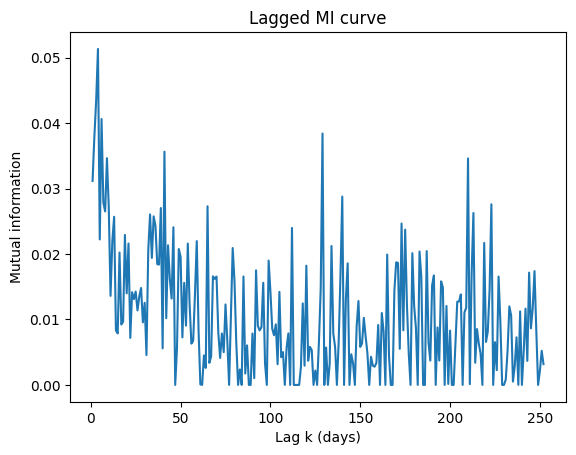

In [144]:
# Plot MI vs lag
plt.figure()
plt.plot(mi_lag.index, mi_lag.values)
plt.title("Lagged MI curve")
plt.xlabel("Lag k (days)")
plt.ylabel("Mutual information")
plt.show()

### Target

#### Forecastability measures

##### Label entropy (baseline difficulty)

Label entropy is just Shannon entropy of the empirical class distribution. It measures how “uncertain” the label is before looking at features: strong class imbalance → low entropy (easy baseline), balanced classes → high entropy (harder baseline).
Entropy-style measures are also used in finance to characterize regime/pattern uncertainty (e.g., symbol entropy applied to bearish/bullish patterns).

In [145]:
target = df["target"].dropna().sort_index()

# empirical class probabilities
p = target.value_counts(normalize=True).sort_index()
entropy = -(p * np.log(p)).sum()
entropy_norm = entropy / np.log(p.size)

print("Class probs:\n", p)
print(f"Normalized entropy = {entropy_norm:.4f} (0=imbalanced, 1=uniform)")

Class probs:
 target
-1.0    0.364425
 0.0    0.332321
 1.0    0.303254
Name: proportion, dtype: float64
Normalized entropy = 0.9974 (0=imbalanced, 1=uniform)


##### MI(lag features; target) for L=20 and L=60

This measures how informative each lagged return is about the future 3-class regime label. MI is 0 iff independent, and it can detect nonlinear relations (unlike linear correlation).

In [146]:
def make_lag_features(series: pd.Series, L: int, first_lag: int = 1) -> pd.DataFrame:
    X = pd.concat([series.shift(i) for i in range(first_lag, L+first_lag)], axis=1)
    X.columns = [f"lag_{i}" for i in range(first_lag, L+first_lag)]
    return X

def target_to_codes(t: pd.Series) -> np.ndarray:
    # robust coding even if labels are -1/0/1
    return pd.Categorical(t).codes

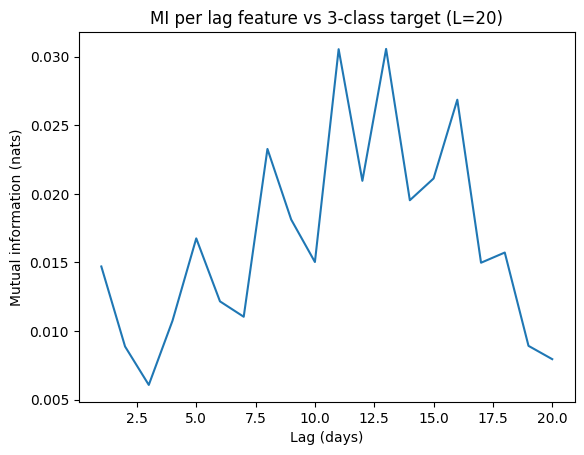

In [147]:
L = 20
X = make_lag_features(lr, L, first_lag=0)
df_lf = X.join(target.rename("target"), how="inner").dropna()

y = target_to_codes(df_lf["target"])
Xv = StandardScaler().fit_transform(df_lf[X.columns].values)  # scaling helps kNN-based MI

mi = mutual_info_classif(Xv, y, n_neighbors=10, random_state=0)
mi_s = pd.Series(mi, index=X.columns).rename("MI_nats")

# Plot MI vs lag index
plt.figure()
plt.plot(range(1, L+1), mi_s.values)
plt.title("MI per lag feature vs 3-class target (L=20)")
plt.xlabel("Lag (days)")
plt.ylabel("Mutual information (nats)")
plt.show()

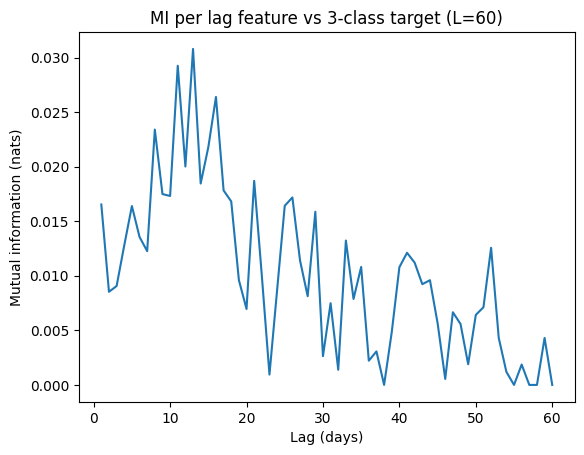

In [148]:
L = 60
X = make_lag_features(lr, L, first_lag=0)
df_lf = X.join(target.rename("target"), how="inner").dropna()

y = target_to_codes(df_lf["target"])
Xv = StandardScaler().fit_transform(df_lf[X.columns].values)

mi = mutual_info_classif(Xv, y, n_neighbors=10, random_state=0)
mi_s = pd.Series(mi, index=X.columns).rename("MI_nats")

plt.figure()
plt.plot(range(1, L+1), mi_s.values)
plt.title("MI per lag feature vs 3-class target (L=60)")
plt.xlabel("Lag (days)")
plt.ylabel("Mutual information (nats)")
plt.show()